In [270]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib import rc

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import sys
import math
import pickle


import itertools

from scipy.optimize import curve_fit

#PERFORMANCE VS NQUBITS FOR ALL GRAPH TYPES - with sorting and tau = 0.3

In [271]:
#data

num_variables_list = [str(num).zfill(3) for num in range(12,24, 2)] 
graph_type_list = [ '3regular', '050', '070', '080', '090', '095', '100','complete']

r_list = range(400)
tau_list =[0.3] # [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)

color_map = {
    "3regular": "blue",
    "050": "red",
    "070": "purple",
    "080": "orange",
    "090": "cyan",
    "095": "pink",
    "complete": "green",
}


In [272]:
#initialize empty dictionaries

entropy_results_dict = {f'{abs}' : {
f'{nqubits}' : {f'{graph}': [0,0] for graph in graph_type_list} for nqubits in num_variables_list} for abs in [True, False]}
print(entropy_results_dict)

cvar_results_dict =  {f'{abs}' : {
f'{nqubits}' : {f'{graph}': [0,0] for graph in graph_type_list} for nqubits in num_variables_list} for abs in [True, False]}
print(cvar_results_dict)

fidelity_results_dict =  {f'{abs}' : {
f'{nqubits}' : {f'{graph}': [[0,0],[0,0],[0,0]] for graph in graph_type_list} for nqubits in num_variables_list} for abs in [True, False]}
print(fidelity_results_dict)

{'True': {'012': {'3regular': [0, 0], '050': [0, 0], '070': [0, 0], '080': [0, 0], '090': [0, 0], '095': [0, 0], '100': [0, 0], 'complete': [0, 0]}, '014': {'3regular': [0, 0], '050': [0, 0], '070': [0, 0], '080': [0, 0], '090': [0, 0], '095': [0, 0], '100': [0, 0], 'complete': [0, 0]}, '016': {'3regular': [0, 0], '050': [0, 0], '070': [0, 0], '080': [0, 0], '090': [0, 0], '095': [0, 0], '100': [0, 0], 'complete': [0, 0]}, '018': {'3regular': [0, 0], '050': [0, 0], '070': [0, 0], '080': [0, 0], '090': [0, 0], '095': [0, 0], '100': [0, 0], 'complete': [0, 0]}, '020': {'3regular': [0, 0], '050': [0, 0], '070': [0, 0], '080': [0, 0], '090': [0, 0], '095': [0, 0], '100': [0, 0], 'complete': [0, 0]}, '022': {'3regular': [0, 0], '050': [0, 0], '070': [0, 0], '080': [0, 0], '090': [0, 0], '095': [0, 0], '100': [0, 0], 'complete': [0, 0]}}, 'False': {'012': {'3regular': [0, 0], '050': [0, 0], '070': [0, 0], '080': [0, 0], '090': [0, 0], '095': [0, 0], '100': [0, 0], 'complete': [0, 0]}, '014':

In [273]:
#fill dictionaries with data from files
for if_adsorting in [True]:  #CHANGE LATER!!!!!!!
    
    for graph in graph_type_list:

        dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                                .format(graph,  shots)

        for n_qubits_i, num_variables in enumerate(num_variables_list):
            N = int(num_variables)
            
            if graph == 'complete':
                num_params = int(2*(N-1)*N/2 + N)
            elif graph == '3regular':
                num_params= int(2*(3*N)/2 + N)
            elif graph == '100':
                density = 1
                num_params = 2*round((N-1)*N*density/2) +N
            else:
                density = float(f"0.{int(graph)}")
                num_params = 2*round((N-1)*N*density/2) +N

            print("qubits = ", N, 'graph', graph)
                
            for alpha in alpha_list:

                for taui, tau in enumerate(tau_list):
                    
                    #print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)
                    
                    dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                        .format(num_variables, num_params, layer, alpha)
                    
                    successes = np.zeros((3, len(r_list)))
                    max_entros = []
                    cvarvalues = []

                    for r in r_list:
                        
                        file_dir_name = dir_name + '/r_{}'\
                                    .format(r)
                        
                        filename = file_dir_name + '/ifadsorting_{}_tau_{}_entro.pkl'\
                                                                .format(if_adsorting,tau)
                        with open(filename, 'rb') as f:
                            data = pickle.load(f)

                        params_list = data["params_list"]
                        if len(params_list) != round(num_params):
                            print("error N, r = ", r, len(params_list))
                            
                        steps_exp_poss_dict = data["steps_exp_poss_dict"]
                        steps_cvar_dict = data["steps_cvar_dict"]
                        steps_entropy_dict = data["steps_entropy_dict"]
                        
                        final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                        poss_list = list(final_exp_poss.values())

                        if poss_list[0] > alpha:
                            successes[0][r] = 1
                        if sum(poss_list[:2]) > alpha:
                            successes[1][r] = 1
                        if sum(poss_list[:3]) > alpha:
                            successes[2][r] = 1

                        exp_opt = list(final_exp_poss.keys())[0]
                        cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]
                        cvarvalues.append(cvar/exp_opt)

                        max_key = max(steps_entropy_dict, key=steps_entropy_dict.get)
                        max_entros.append(steps_entropy_dict[max_key])
                    
                    for i in range(3):
                        fidelity_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][i][0] = np.mean(successes[i])
                        fidelity_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][i][1] = np.std(successes[i], axis=0, ddof=1)

                    cvar_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][0] = np.mean(cvarvalues)
                    cvar_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][1] = np.std(cvarvalues, axis=0, ddof=1)

                    entropy_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][0] = np.mean(max_entros)
                    entropy_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][1] = np.std(max_entros, axis=0, ddof=1)



qubits =  12 graph 3regular
qubits =  14 graph 3regular
qubits =  16 graph 3regular
qubits =  18 graph 3regular
qubits =  20 graph 3regular
qubits =  22 graph 3regular
qubits =  12 graph 050
qubits =  14 graph 050
qubits =  16 graph 050
qubits =  18 graph 050
qubits =  20 graph 050
qubits =  22 graph 050
qubits =  12 graph 070
qubits =  14 graph 070
qubits =  16 graph 070
qubits =  18 graph 070
qubits =  20 graph 070
qubits =  22 graph 070
qubits =  12 graph 080
qubits =  14 graph 080
qubits =  16 graph 080
qubits =  18 graph 080
qubits =  20 graph 080
qubits =  22 graph 080
qubits =  12 graph 090
qubits =  14 graph 090
qubits =  16 graph 090
qubits =  18 graph 090
qubits =  20 graph 090
qubits =  22 graph 090
qubits =  12 graph 095
qubits =  14 graph 095
qubits =  16 graph 095
qubits =  18 graph 095
qubits =  20 graph 095
qubits =  22 graph 095
qubits =  12 graph 100
qubits =  14 graph 100
qubits =  16 graph 100
qubits =  18 graph 100
qubits =  20 graph 100
qubits =  22 graph 100
qubi

0.03524016882741375 1.5185540837638023 1.4833139149363885 1.553794252591216
0.03524016882741375 1.8236137958281637 1.78837362700075 1.8588539646555775
0.03524016882741375 1.232614221827609 1.1973740530001953 1.2678543906550228
0.03524016882741375 1.7276987715734953 1.6924586027460815 1.762938940400909
0.03524016882741375 2.0514974454557726 2.016257276628359 2.0867376142831864
0.03524016882741375 2.034569694195371 1.999329525367957 2.0698098630227846
0.030403937421739764 1.890776093303771 1.8603721558820312 1.9211800307255107
0.030403937421739764 1.8593904403056951 1.8289865028839554 1.8897943777274349
0.030403937421739764 2.513154727126191 2.482750789704451 2.543558664547931
0.030403937421739764 3.2020963646267386 3.1716924272049987 3.2325003020484786
0.030403937421739764 3.777699184566838 3.747295247145098 3.808103121988578
0.030403937421739764 4.0535005571824305 4.0230966197606906 4.0839044946041705
0.030141368679294525 1.9437301442916983 1.9135887756124037 1.973871512970993
0.030141

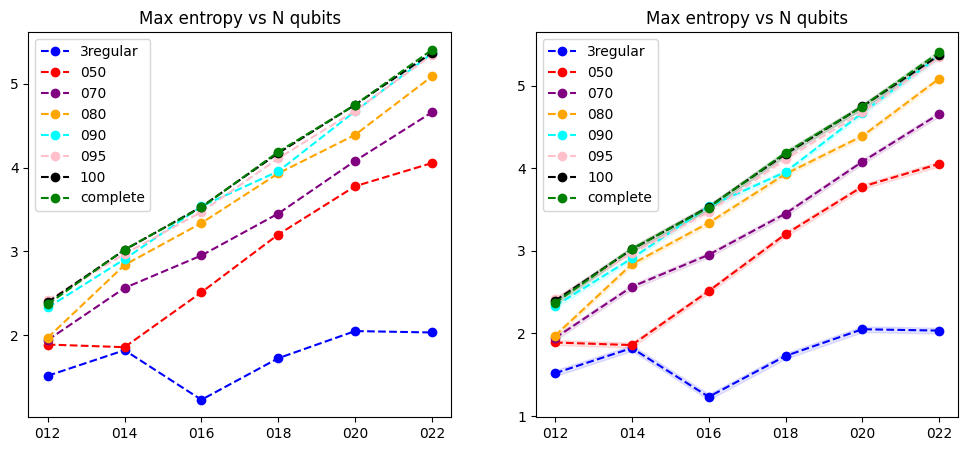

In [289]:
#entropy plot

#ADD FALSE LATER!

f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

for graph in graph_type_list:
    color = color_map.get(graph, "black")
    entropies = []
    for nqubits in num_variables_list:
        entropies.append(entropy_results_dict['True'][f'{nqubits}'][graph][0])
    ax1.plot(num_variables_list, entropies, "o--", color = color, label = f'{graph}')
    ax1.set_title('Max entropy vs N qubits')
ax1.legend()

for graph in graph_type_list:
    color = color_map.get(graph, "black")
    entropies = []
    lerror_list = []
    uerror_list = [] 

    for nqubits in num_variables_list:
        entropies.append(entropy_results_dict['True'][f'{nqubits}'][graph][0])

        z = 1.96  # Z-score for 95% confidence

        std = entropy_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][1]
        margin_of_error = z * (std/ np.sqrt(len(r_list)))
        lower_bound = entropy_results_dict['True'][f'{nqubits}'][graph][0] - margin_of_error 
        upper_bound = entropy_results_dict['True'][f'{nqubits}'][graph][0] + margin_of_error 
        print(margin_of_error, entropy_results_dict['True'][f'{nqubits}'][graph][0], lower_bound, upper_bound )
        lerror_list.append(lower_bound)
        uerror_list.append(upper_bound)
        # lerror_list.append(margin_of_error)
        # uerror_list.append(margin_of_error)
    ax2.plot(num_variables_list, entropies, "o--", color = color, label = f'{graph}')
    # ax2.errorbar(num_variables_list, y = entropies, yerr = [lerror_list, uerror_list], color = color)
    ax2.fill_between(num_variables_list, lerror_list, uerror_list, color= color, alpha=0.1)
    ax2.set_title('Max entropy vs N qubits')
ax2.legend()

[12. 14. 16. 18. 20. 22.]
[1.51855408 1.8236138  1.23261422 1.72769877 2.05149745 2.03456969]
linear [0.05369734 0.81856996]
sub [ 0.84479343 -0.64437369]
poly [ 0.00914846 -0.2573504   3.35574364]
Sum of Squared Residuals (SSR):
  Linear Model: 0.30
  Sublinear Model: 0.31
  Polynomial Model: 0.25


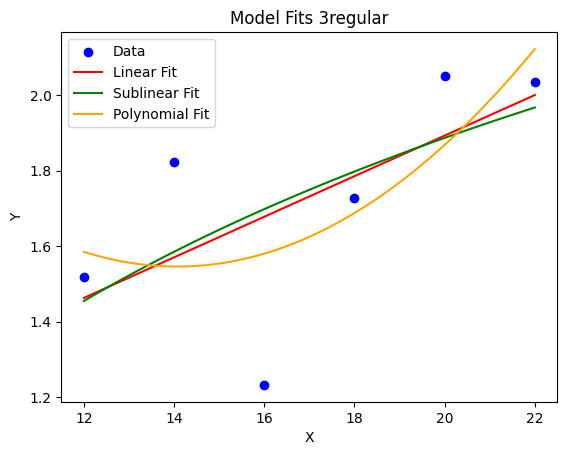

[12. 14. 16. 18. 20. 22.]
[1.89077609 1.85939044 2.51315473 3.20209636 3.77769918 4.05350056]
linear [ 0.24653557 -1.3083352 ]
sub [ 4.02848851 -8.446481  ]
poly [0.00546111 0.06085774 0.20621341]
Sum of Squared Residuals (SSR):
  Linear Model: 0.19
  Sublinear Model: 0.28
  Polynomial Model: 0.17


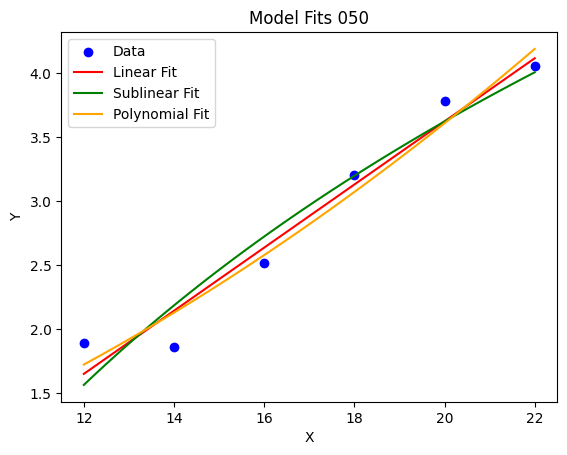

[12. 14. 16. 18. 20. 22.]
[1.94373014 2.56497171 2.95205655 3.45172119 4.0796141  4.6585377 ]
linear [ 0.26596614 -1.2463191 ]
sub [ 4.36631133 -9.00419874]
poly [ 0.00335555  0.15187755 -0.31571417]
Sum of Squared Residuals (SSR):
  Linear Model: 0.02
  Sublinear Model: 0.09
  Polynomial Model: 0.02


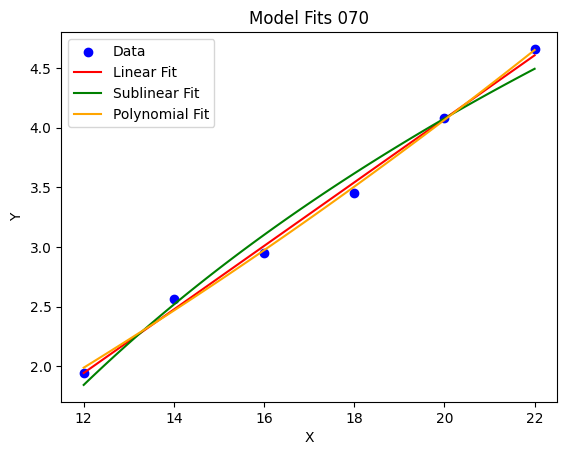

[12. 14. 16. 18. 20. 22.]
[1.97180502 2.83914174 3.33825237 3.93047274 4.39004733 5.08610595]
linear [ 0.29737774 -1.46278407]
sub [  4.91861049 -10.2398881 ]
poly [-0.00452917  0.45136961 -2.71887461]
Sum of Squared Residuals (SSR):
  Linear Model: 0.05
  Sublinear Model: 0.04
  Polynomial Model: 0.04


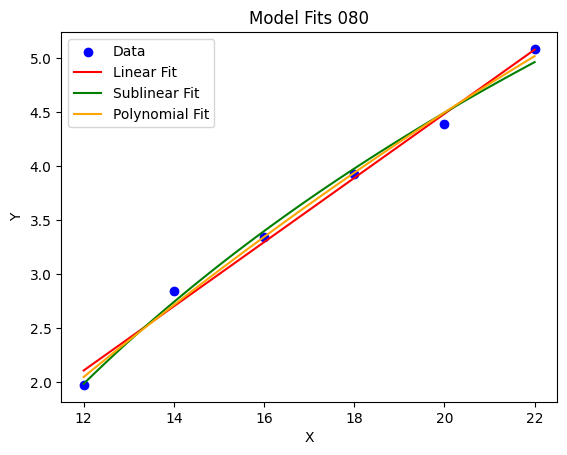

[12. 14. 16. 18. 20. 22.]
[2.3322907  2.9081181  3.53760305 3.95538325 4.67087278 5.35913828]
linear [ 0.29771832 -1.26731034]
sub [ 4.88620235 -9.94748373]
poly [ 0.00404558  0.16016876 -0.14533753]
Sum of Squared Residuals (SSR):
  Linear Model: 0.03
  Sublinear Model: 0.11
  Polynomial Model: 0.02


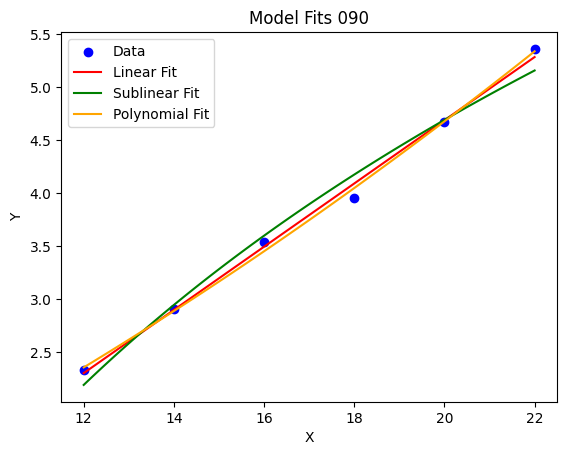

[12. 14. 16. 18. 20. 22.]
[2.4184474  2.97030685 3.46992305 4.10950774 4.67558005 5.34336613]
linear [ 0.29114283 -1.11823953]
sub [ 4.77774094 -9.60517204]
poly [ 0.00377436  0.16281445 -0.07148257]
Sum of Squared Residuals (SSR):
  Linear Model: 0.01
  Sublinear Model: 0.10
  Polynomial Model: 0.00


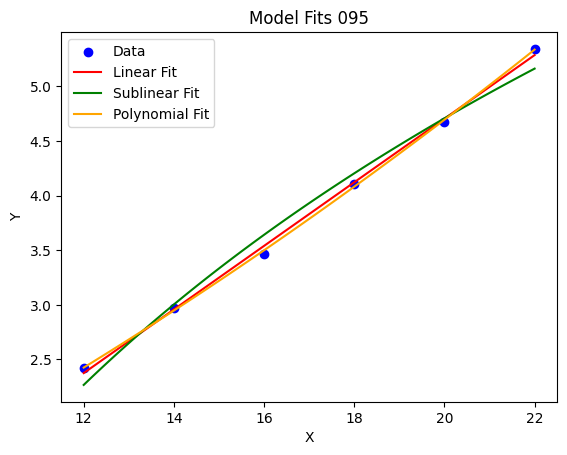

[12. 14. 16. 18. 20. 22.]
[2.39572397 3.01735657 3.53250632 4.17184414 4.74810143 5.36791571]
linear [ 0.29560759 -1.15308762]
sub [ 4.86290276 -9.80361836]
poly [ 0.00105062  0.25988656 -0.86171608]
Sum of Squared Residuals (SSR):
  Linear Model: 0.00
  Sublinear Model: 0.06
  Polynomial Model: 0.00


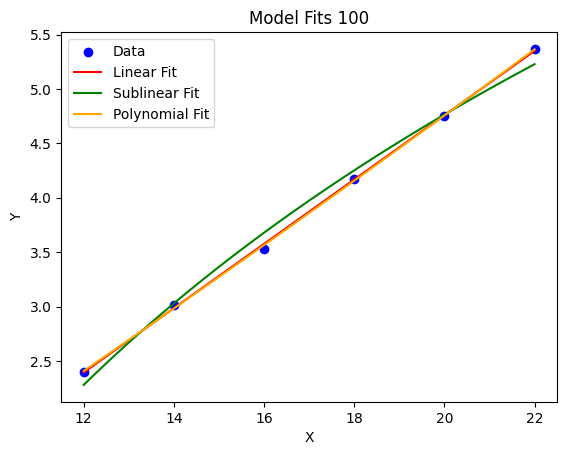

[12. 14. 16. 18. 20. 22.]
[2.37048596 3.02335143 3.52428045 4.18710883 4.74758178 5.40351293]
linear [ 0.30000935 -1.22410533]
sub [  4.93538098 -10.00363545]
poly [ 0.00113171  0.26153104 -0.91024306]
Sum of Squared Residuals (SSR):
  Linear Model: 0.01
  Sublinear Model: 0.07
  Polynomial Model: 0.01


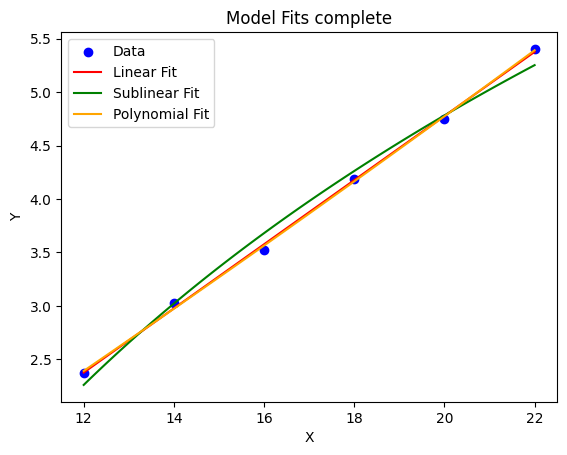

In [275]:
# 1. Define the candidate models
def linear_model(x, a, b):
    return a*x + b

def sublinear_model(x, a, b):
    return a * np.log(x) + b 

def polynomial_model(x, a, b, c):
    return a * x**2 + b * x + c

for graph in graph_type_list:
    color = color_map.get(graph, "black")
    entropies = []
    for nqubits in num_variables_list:
        entropies.append(entropy_results_dict['True'][f'{nqubits}'][graph][0])


    # 2. Generate or load your data (replace these with your data)
    # x_data = np.linspace(1, 10, 50)  # Replace with your x values
    # y_data = 2.5 * x_data + 3 + np.random.normal(0, 2, len(x_data))  # Replace with your y values
    x_data = np.array([float(variable) for variable in num_variables_list])
    y_data = np.array(entropies)
    print(x_data)
    print(y_data)

    # 3. Fit the data to each model
    params_linear, _ = curve_fit(linear_model, x_data, y_data)
    params_sublinear, _ = curve_fit(sublinear_model, x_data, y_data)
    params_polynomial, _ = curve_fit(polynomial_model, x_data, y_data)

    print('linear',params_linear)
    print('sub', params_sublinear)
    print('poly', params_polynomial)

    # 4. Calculate goodness-of-fit (sum of squared residuals)
    def compute_ssr(model, params, x, y):
        y_fit = model(x, *params)
        residuals = y - y_fit
        return np.sum(residuals**2)

    ssr_linear = compute_ssr(linear_model, params_linear, x_data, y_data)
    ssr_sublinear = compute_ssr(sublinear_model, params_sublinear, x_data, y_data)
    ssr_polynomial = compute_ssr(polynomial_model, params_polynomial, x_data, y_data)

    # Print SSR values for comparison
    print(f"Sum of Squared Residuals (SSR):")
    print(f"  Linear Model: {ssr_linear:.2f}")
    print(f"  Sublinear Model: {ssr_sublinear:.2f}")
    print(f"  Polynomial Model: {ssr_polynomial:.2f}")

    # 5. Plot the data and fits
    plt.scatter(x_data, y_data, label="Data", color="blue")

    # Generate x values for plotting fits
    x_fit = np.linspace(min(x_data), max(x_data), 100)

    # Plot the fitted models
    plt.plot(x_fit, linear_model(x_fit, *params_linear), label="Linear Fit", color="red")
    plt.plot(x_fit, sublinear_model(x_fit, *params_sublinear), label="Sublinear Fit", color="green")
    plt.plot(x_fit, polynomial_model(x_fit, *params_polynomial), label="Polynomial Fit", color="orange")

    # Add labels, legend, and show the plot
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.title(f'Model Fits {graph}')
    plt.show()

True 020
True 022
True 020
True 022
True 020
True 022


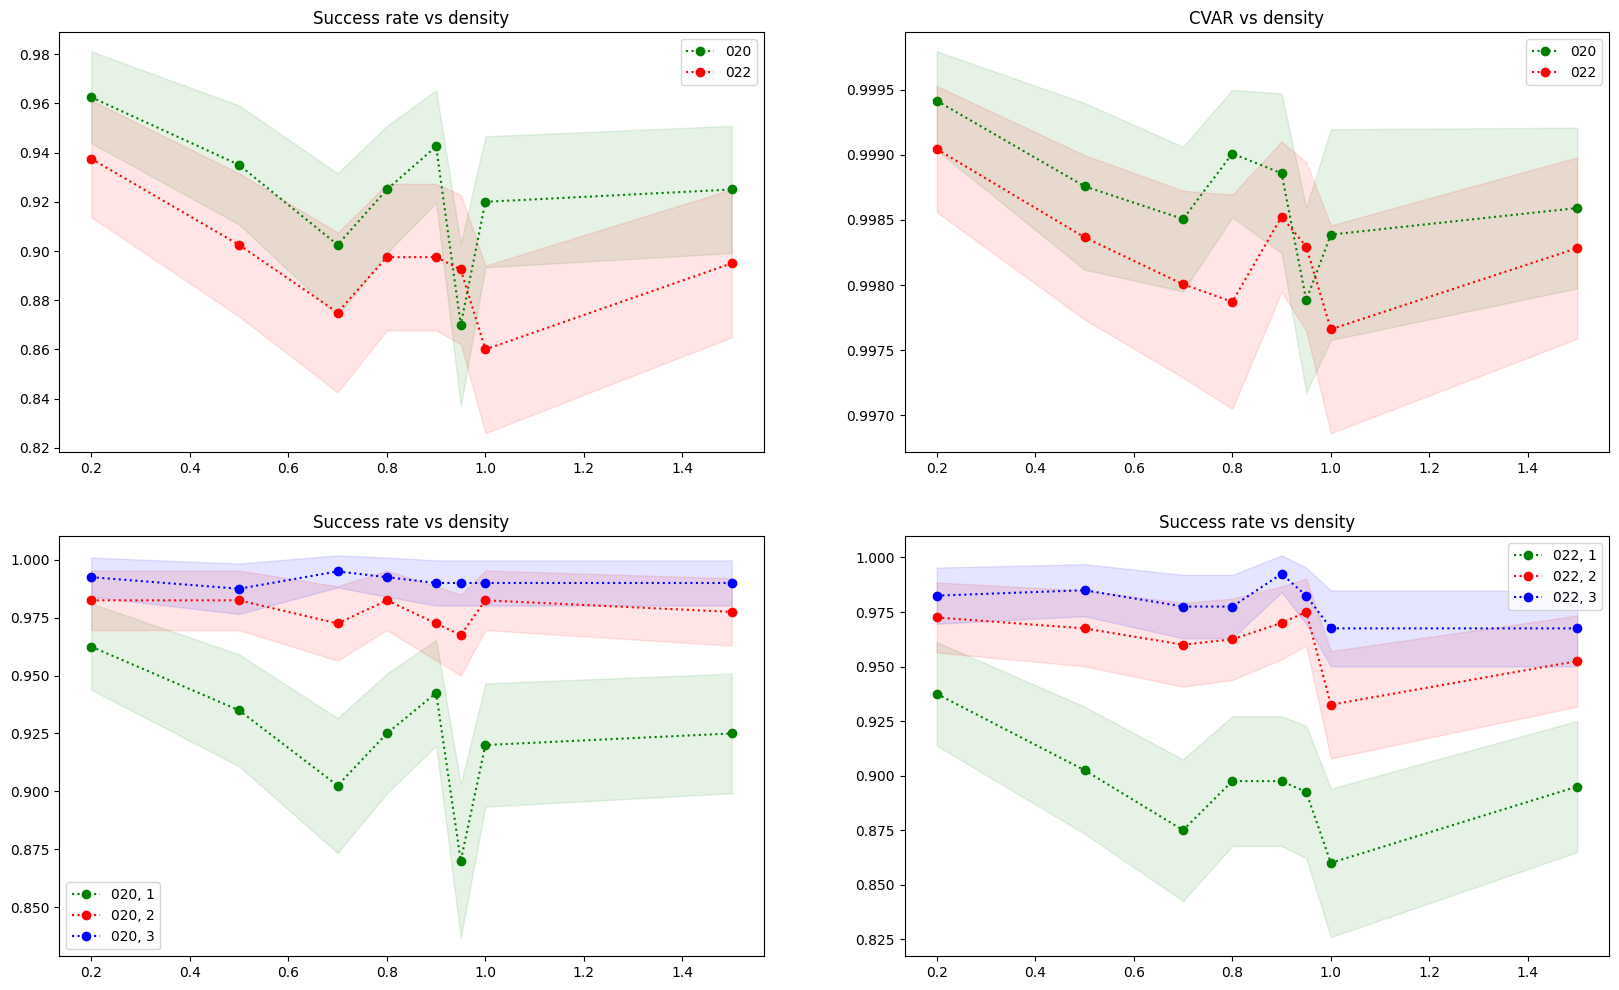

In [288]:
#performance vs density


f = plt.figure(figsize=(20, 12))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)


color = color_map.get('complete', "black")

for num_variables in ['020','022']:
    print(if_adsorting, num_variables)

    density_list = []    
    means = []
    lows = []
    ups = []

    for graph in graph_type_list:

        if graph == 'complete':
            density =1.5 #ONLY FOR PLOT CLARITY!!
        elif graph == '3regular':
            density = ((3*N)/2)/((N-1)*N/2 )
        elif graph == '100':
            density = 1
        else:
            density = float(f"0.{int(graph)}")

        density_list.append(density)

        z = 1.96  # Z-score for 95% confidence

        mean = fidelity_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][0][0]
        std = fidelity_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][0][1]

        # Compute confidence intervals
        margin_of_error = z * (std/ np.sqrt(len(r_list)))
        lower_bound = mean - margin_of_error 
        upper_bound = mean + margin_of_error 

        means.append(mean)
        lows.append(lower_bound)
        ups.append(upper_bound)

    ax1.plot(density_list, means,"o:", color = color, label = f'{num_variables}')
    ax1.fill_between(density_list, lows, ups, color= color, alpha=0.1)
    ax1.set_title('Success rate vs density')
    color = color_map.get('050', "black")
    ax1.legend()
    
color = color_map.get('complete', "black")

for num_variables in ['020','022']:
    print(if_adsorting, num_variables)

    density_list = []    
    means = []
    lows = []
    ups = []

    for graph in graph_type_list:

        if graph == 'complete':
            density =1.5 #ONLY FOR PLOT CLARITY!!
        elif graph == '3regular':
            density = ((3*N)/2)/((N-1)*N/2 )
        elif graph == '100':
            density = 1
        else:
            density = float(f"0.{int(graph)}")

        density_list.append(density)

        z = 1.96  # Z-score for 95% confidence

        mean = cvar_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][0]
        std = cvar_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][1]

        # Compute confidence intervals
        margin_of_error = z * (std/ np.sqrt(len(r_list)))
        lower_bound = mean - margin_of_error 
        upper_bound = mean + margin_of_error 

        means.append(mean)
        lows.append(lower_bound)
        ups.append(upper_bound)

    ax2.plot(density_list, means,"o:", color = color, label = f'{num_variables}')
    ax2.fill_between(density_list, lows, ups, color= color, alpha=0.1)
    ax2.set_title('CVAR vs density')
    color = color_map.get('050', "black")
    ax2.legend()


color = color_map.get('complete', "black")

for num_variables in ['020']:
    print(if_adsorting, num_variables)

    for numoptimal in range(3):
        density_list = []    
        means = []
        lows = []
        ups = []

        for graph in graph_type_list:

            if graph == 'complete':
                density =1.5 #ONLY FOR PLOT CLARITY!!
            elif graph == '3regular':
                density = ((3*N)/2)/((N-1)*N/2 )
            elif graph == '100':
                density = 1
            else:
                density = float(f"0.{int(graph)}")

            density_list.append(density)

            z = 1.96  # Z-score for 95% confidence

            mean = fidelity_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][numoptimal][0]
            std = fidelity_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][numoptimal][1]

            # Compute confidence intervals
            margin_of_error = z * (std/ np.sqrt(len(r_list)))
            lower_bound = mean - margin_of_error 
            upper_bound = mean + margin_of_error 

            means.append(mean)
            lows.append(lower_bound)
            ups.append(upper_bound)

        ax3.plot(density_list, means,"o:", color = color, label = f'{num_variables}, {numoptimal+1}')
        ax3.fill_between(density_list, lows, ups, color= color, alpha=0.1)
        ax3.set_title('Success rate vs density')
        color = color_map.get('050', "black")
        if numoptimal >=1:
            color = color_map.get('3regular', "black")
        ax3.legend()

color = color_map.get('complete', "black")

for num_variables in ['022']:
    print(if_adsorting, num_variables)

    for numoptimal in range(3):
        density_list = []    
        means = []
        lows = []
        ups = []

        for graph in graph_type_list:

            if graph == 'complete':
                density =1.5 #ONLY FOR PLOT CLARITY!!
            elif graph == '3regular':
                density = ((3*N)/2)/((N-1)*N/2 )
            elif graph == '100':
                density = 1
            else:
                density = float(f"0.{int(graph)}")

            density_list.append(density)

            z = 1.96  # Z-score for 95% confidence

            mean = fidelity_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][numoptimal][0]
            std = fidelity_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][numoptimal][1]

            # Compute confidence intervals
            margin_of_error = z * (std/ np.sqrt(len(r_list)))
            lower_bound = mean - margin_of_error 
            upper_bound = mean + margin_of_error 

            means.append(mean)
            lows.append(lower_bound)
            ups.append(upper_bound)

        ax4.plot(density_list, means,"o:", color = color, label = f'{num_variables}, {numoptimal+1}')
        ax4.fill_between(density_list, lows, ups, color= color, alpha=0.1)
        ax4.set_title('Success rate vs density')
        color = color_map.get('050', "black")
        if numoptimal >=1:
            color = color_map.get('3regular', "black")
        ax4.legend()


True 012
True 014
True 016
True 018
True 020
True 022
True 012
True 014
True 016
True 018
True 020
True 022
True 012
True 014
True 016
True 018
True 020
True 022
True 012
True 014
True 016
True 018
True 020
True 022
True 012
True 014
True 016
True 018
True 020
True 022
True 012
True 014
True 016
True 018
True 020
True 022
True 012
True 014
True 016
True 018
True 020
True 022
True 012
True 014
True 016
True 018
True 020
True 022
True 012
True 014
True 016
True 018
True 020
True 022
True 012
True 014
True 016
True 018
True 020
True 022
True 012
True 014
True 016
True 018
True 020
True 022
True 012
True 014
True 016
True 018
True 020
True 022
True 012
True 014
True 016
True 018
True 020
True 022
True 012
True 014
True 016
True 018
True 020
True 022
True 012
True 014
True 016
True 018
True 020
True 022
True 012
True 014
True 016
True 018
True 020
True 022
True 012
True 014
True 016
True 018
True 020
True 022
True 012
True 014
True 016
True 018
True 020
True 022
True 012
True 014
True 016
T

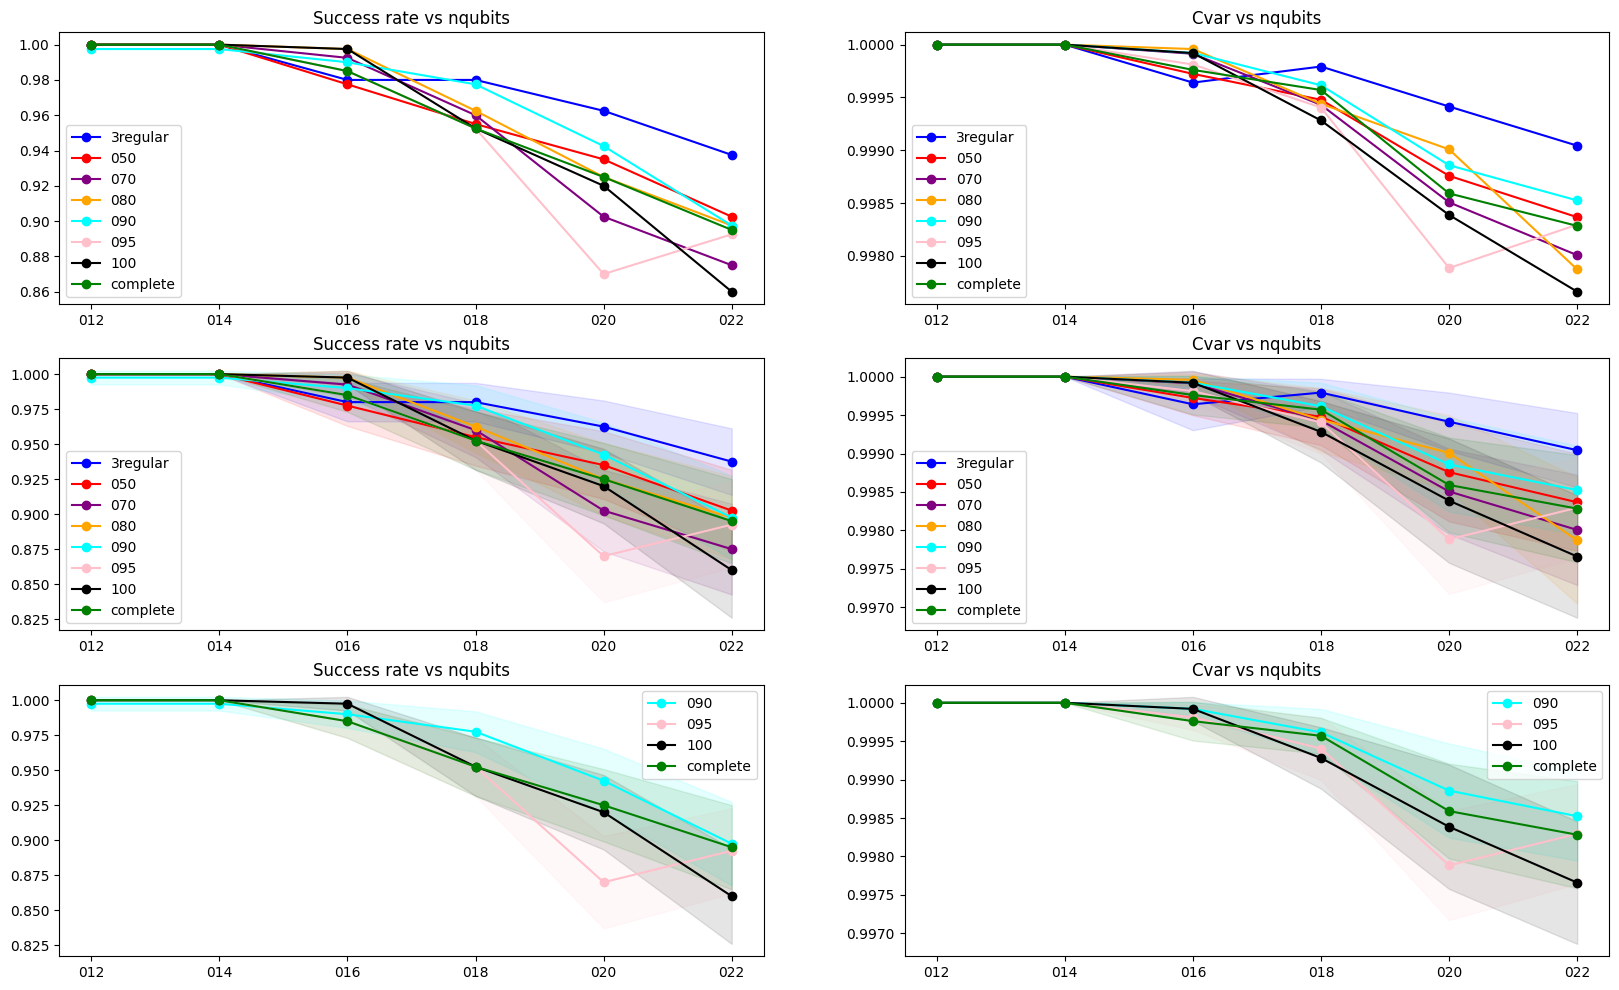

In [277]:
#performance vs qubits

f = plt.figure(figsize=(20, 12))
ax1 = f.add_subplot(321)
ax2 = f.add_subplot(322)
ax3 = f.add_subplot(323)
ax4 = f.add_subplot(324)
ax5 = f.add_subplot(325)
ax6 = f.add_subplot(326)


for graph in graph_type_list:

    density_list = []    
    means = []
    lows = []
    ups = []

    color = color_map.get(graph, "black")

    for num_variables in num_variables_list:
        print(if_adsorting, num_variables)

        if graph == 'complete':
            density =1.5 #ONLY FOR PLOT CLARITY!!
        elif graph == '3regular':
            density = ((3*N)/2)/((N-1)*N/2 )
        elif graph == '100':
            density = 1
        else:
            density = float(f"0.{int(graph)}")

        density_list.append(density)

        z = 1.96  # Z-score for 95% confidence

        mean = fidelity_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][0][0]
        std = fidelity_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][0][1]

        # Compute confidence intervals
        margin_of_error = z * (std/ np.sqrt(len(r_list)))
        lower_bound = mean - margin_of_error 
        upper_bound = mean + margin_of_error 

        means.append(mean)
        lows.append(lower_bound)
        ups.append(upper_bound)

    ax1.plot(num_variables_list, means,"o-", color = color, label = f'{graph}')
    # ax1.fill_between(num_variables_list, lows, ups, color= color, alpha=0.1)
    ax1.set_title('Success rate vs nqubits')
    ax1.legend()

for graph in graph_type_list:

    density_list = []    
    means = []
    lows = []
    ups = []

    color = color_map.get(graph, "black")

    for num_variables in num_variables_list:
        print(if_adsorting, num_variables)

        if graph == 'complete':
            density =1.5 #ONLY FOR PLOT CLARITY!!
        elif graph == '3regular':
            density = ((3*N)/2)/((N-1)*N/2 )
        elif graph == '100':
            density = 1
        else:
            density = float(f"0.{int(graph)}")

        density_list.append(density)

        z = 1.96  # Z-score for 95% confidence

        mean = cvar_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][0]
        std = cvar_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][1]

        # Compute confidence intervals
        margin_of_error = z * (std/ np.sqrt(len(r_list)))
        lower_bound = mean - margin_of_error 
        upper_bound = mean + margin_of_error 

        means.append(mean)
        lows.append(lower_bound)
        ups.append(upper_bound)

    ax2.plot(num_variables_list, means,"o-", color = color, label = f'{graph}')
    # ax1.fill_between(num_variables_list, lows, ups, color= color, alpha=0.1)
    ax2.set_title('Cvar vs nqubits')
    ax2.legend()

for graph in graph_type_list:

    density_list = []    
    means = []
    lows = []
    ups = []

    color = color_map.get(graph, "black")

    for num_variables in num_variables_list:
        print(if_adsorting, num_variables)

        if graph == 'complete':
            density =1.5 #ONLY FOR PLOT CLARITY!!
        elif graph == '3regular':
            density = ((3*N)/2)/((N-1)*N/2 )
        elif graph == '100':
            density = 1
        else:
            density = float(f"0.{int(graph)}")

        density_list.append(density)

        z = 1.96  # Z-score for 95% confidence

        mean = fidelity_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][0][0]
        std = fidelity_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][0][1]

        # Compute confidence intervals
        margin_of_error = z * (std/ np.sqrt(len(r_list)))
        lower_bound = mean - margin_of_error 
        upper_bound = mean + margin_of_error 

        means.append(mean)
        lows.append(lower_bound)
        ups.append(upper_bound)

    ax3.plot(num_variables_list, means,"o-", color = color, label = f'{graph}')
    ax3.fill_between(num_variables_list, lows, ups, color= color, alpha=0.1)
    ax3.set_title('Success rate vs nqubits')
    ax3.legend()

for graph in graph_type_list:

    density_list = []    
    means = []
    lows = []
    ups = []

    color = color_map.get(graph, "black")

    for num_variables in num_variables_list:
        print(if_adsorting, num_variables)

        if graph == 'complete':
            density =1.5 #ONLY FOR PLOT CLARITY!!
        elif graph == '3regular':
            density = ((3*N)/2)/((N-1)*N/2 )
        elif graph == '100':
            density = 1
        else:
            density = float(f"0.{int(graph)}")

        density_list.append(density)

        z = 1.96  # Z-score for 95% confidence

        mean = cvar_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][0]
        std = cvar_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][1]

        # Compute confidence intervals
        margin_of_error = z * (std/ np.sqrt(len(r_list)))
        lower_bound = mean - margin_of_error 
        upper_bound = mean + margin_of_error 

        means.append(mean)
        lows.append(lower_bound)
        ups.append(upper_bound)

    ax4.plot(num_variables_list, means,"o-", color = color, label = f'{graph}')
    ax4.fill_between(num_variables_list, lows, ups, color= color, alpha=0.1)
    ax4.set_title('Cvar vs nqubits')
    ax4.legend()

for graph in ['090', '095','100','complete']:

    density_list = []    
    means = []
    lows = []
    ups = []

    color = color_map.get(graph, "black")

    for num_variables in num_variables_list:
        print(if_adsorting, num_variables)

        if graph == 'complete':
            density =1.5 #ONLY FOR PLOT CLARITY!!
        elif graph == '3regular':
            density = ((3*N)/2)/((N-1)*N/2 )
        elif graph == '100':
            density = 1
        else:
            density = float(f"0.{int(graph)}")

        density_list.append(density)

        z = 1.96  # Z-score for 95% confidence

        mean = fidelity_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][0][0]
        std = fidelity_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][0][1]

        # Compute confidence intervals
        margin_of_error = z * (std/ np.sqrt(len(r_list)))
        lower_bound = mean - margin_of_error 
        upper_bound = mean + margin_of_error 

        means.append(mean)
        lows.append(lower_bound)
        ups.append(upper_bound)

    ax5.plot(num_variables_list, means,"o-", color = color, label = f'{graph}')
    ax5.fill_between(num_variables_list, lows, ups, color= color, alpha=0.1)
    ax5.set_title('Success rate vs nqubits')
    ax5.legend()

for graph in ['090', '095','100','complete']:

    density_list = []    
    means = []
    lows = []
    ups = []

    color = color_map.get(graph, "black")

    for num_variables in num_variables_list:
        print(if_adsorting, num_variables)

        if graph == 'complete':
            density =1.5 #ONLY FOR PLOT CLARITY!!
        elif graph == '3regular':
            density = ((3*N)/2)/((N-1)*N/2 )
        elif graph == '100':
            density = 1
        else:
            density = float(f"0.{int(graph)}")

        density_list.append(density)

        z = 1.96  # Z-score for 95% confidence

        mean = cvar_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][0]
        std = cvar_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][1]

        # Compute confidence intervals
        margin_of_error = z * (std/ np.sqrt(len(r_list)))
        lower_bound = mean - margin_of_error 
        upper_bound = mean + margin_of_error 

        means.append(mean)
        lows.append(lower_bound)
        ups.append(upper_bound)

    ax6.plot(num_variables_list, means,"o-", color = color, label = f'{graph}')
    ax6.fill_between(num_variables_list, lows, ups, color= color, alpha=0.1)
    ax6.set_title('Cvar vs nqubits')
    ax6.legend()


#END HERE!!!!!!!!!!!!!!!!!!!!!!!!!!

In [278]:
#FIT

# #entropy plot
# f = plt.figure(figsize=(12, 5))
# ax1 = f.add_subplot(121)
# ax2 = f.add_subplot(122)

for graph in graph_type_list:
    color = color_map.get(graph, "black")
    entropies = []
    for nqubits in num_variables_list:
        entropies.append(entropy_results_dict['True'][f'{nqubits}'][graph][0])
#     ax1.plot(num_variables_list, entropies, "o--", color = color, label = f'{graph}')
#     ax1.set_title('Max entropy vs N qubits')
# ax1.legend()

# for graph in graph_type_list:
#     color = color_map.get(graph, "black")
#     entropies = []
#     for nqubits in num_variables_list:
#         entropies.append(entropy_results_dict['True'][f'{nqubits}'][graph][0])
#     ax2.plot(num_variables_list, entropies, "o--", color = color, label = f'{graph}')
#     ax2.set_title('Max entropy vs N qubits')
# ax2.legend()
print(entropies)

[2.3704859647567758, 3.023351428535768, 3.5242804472414355, 4.187108828359473, 4.747581783856408, 5.403512926617015]


[12. 14. 16. 18. 20. 22.]
[1.51855408 1.8236138  1.23261422 1.72769877 2.05149745 2.03456969]
linear [0.05369734 0.81856996]
sub [ 0.84479343 -0.64437369]
poly [ 0.00914846 -0.2573504   3.35574364]
Sum of Squared Residuals (SSR):
  Linear Model: 0.30
  Sublinear Model: 0.31
  Polynomial Model: 0.25


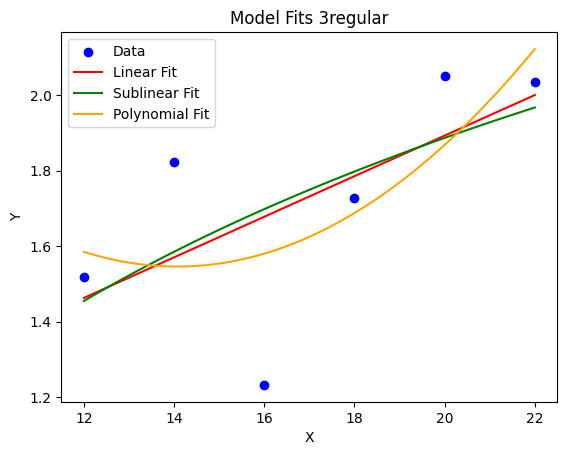

[12. 14. 16. 18. 20. 22.]
[1.89077609 1.85939044 2.51315473 3.20209636 3.77769918 4.05350056]
linear [ 0.24653557 -1.3083352 ]
sub [ 4.02848851 -8.446481  ]
poly [0.00546111 0.06085774 0.20621341]
Sum of Squared Residuals (SSR):
  Linear Model: 0.19
  Sublinear Model: 0.28
  Polynomial Model: 0.17


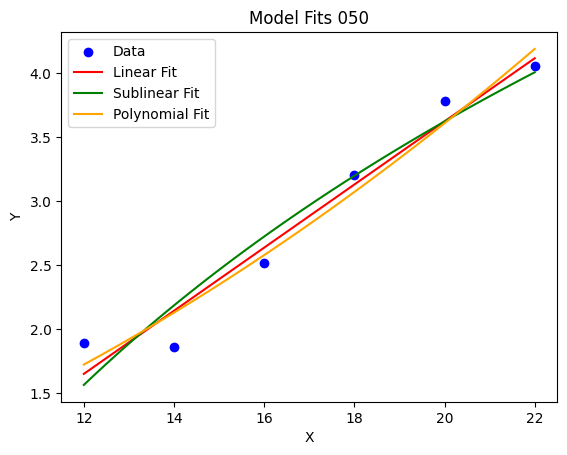

[12. 14. 16. 18. 20. 22.]
[1.94373014 2.56497171 2.95205655 3.45172119 4.0796141  4.6585377 ]
linear [ 0.26596614 -1.2463191 ]
sub [ 4.36631133 -9.00419874]
poly [ 0.00335555  0.15187755 -0.31571417]
Sum of Squared Residuals (SSR):
  Linear Model: 0.02
  Sublinear Model: 0.09
  Polynomial Model: 0.02


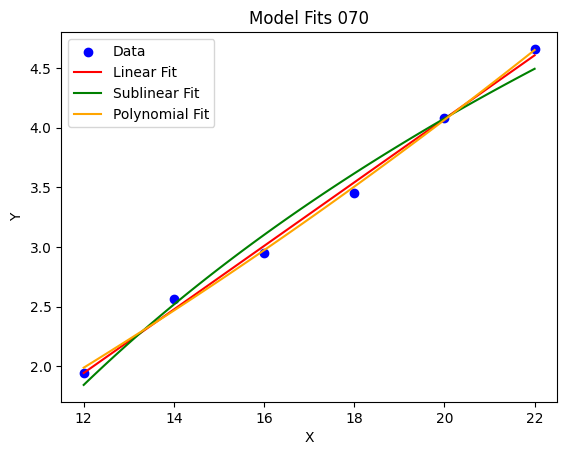

[12. 14. 16. 18. 20. 22.]
[1.97180502 2.83914174 3.33825237 3.93047274 4.39004733 5.08610595]
linear [ 0.29737774 -1.46278407]
sub [  4.91861049 -10.2398881 ]
poly [-0.00452917  0.45136961 -2.71887461]
Sum of Squared Residuals (SSR):
  Linear Model: 0.05
  Sublinear Model: 0.04
  Polynomial Model: 0.04


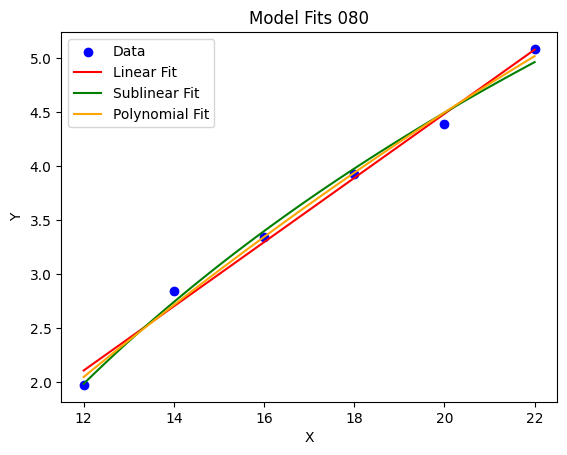

[12. 14. 16. 18. 20. 22.]
[2.3322907  2.9081181  3.53760305 3.95538325 4.67087278 5.35913828]
linear [ 0.29771832 -1.26731034]
sub [ 4.88620235 -9.94748373]
poly [ 0.00404558  0.16016876 -0.14533753]
Sum of Squared Residuals (SSR):
  Linear Model: 0.03
  Sublinear Model: 0.11
  Polynomial Model: 0.02


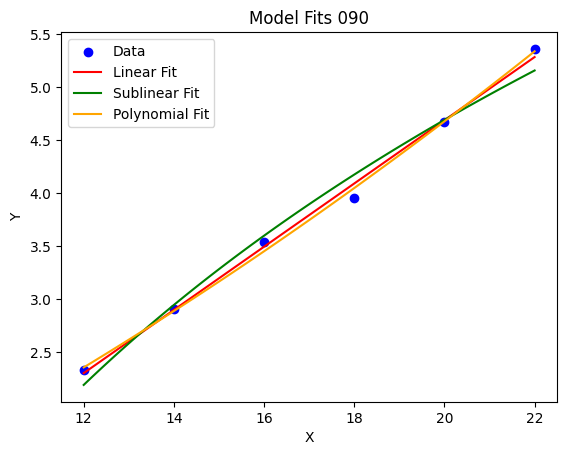

[12. 14. 16. 18. 20. 22.]
[2.4184474  2.97030685 3.46992305 4.10950774 4.67558005 5.34336613]
linear [ 0.29114283 -1.11823953]
sub [ 4.77774094 -9.60517204]
poly [ 0.00377436  0.16281445 -0.07148257]
Sum of Squared Residuals (SSR):
  Linear Model: 0.01
  Sublinear Model: 0.10
  Polynomial Model: 0.00


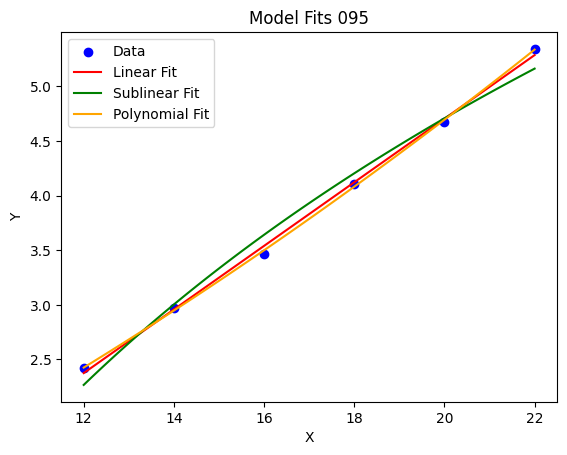

[12. 14. 16. 18. 20. 22.]
[2.39572397 3.01735657 3.53250632 4.17184414 4.74810143 5.36791571]
linear [ 0.29560759 -1.15308762]
sub [ 4.86290276 -9.80361836]
poly [ 0.00105062  0.25988656 -0.86171608]
Sum of Squared Residuals (SSR):
  Linear Model: 0.00
  Sublinear Model: 0.06
  Polynomial Model: 0.00


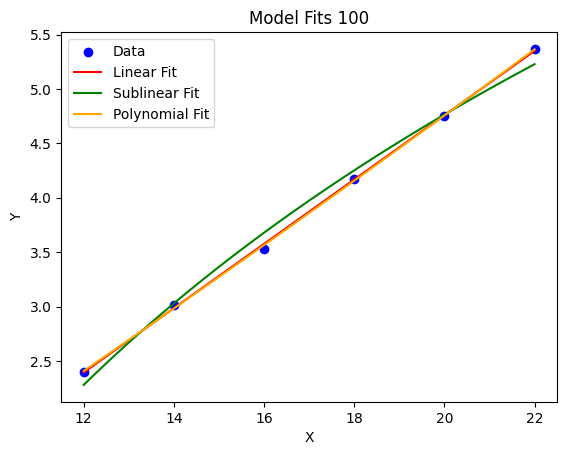

[12. 14. 16. 18. 20. 22.]
[2.37048596 3.02335143 3.52428045 4.18710883 4.74758178 5.40351293]
linear [ 0.30000935 -1.22410533]
sub [  4.93538098 -10.00363545]
poly [ 0.00113171  0.26153104 -0.91024306]
Sum of Squared Residuals (SSR):
  Linear Model: 0.01
  Sublinear Model: 0.07
  Polynomial Model: 0.01


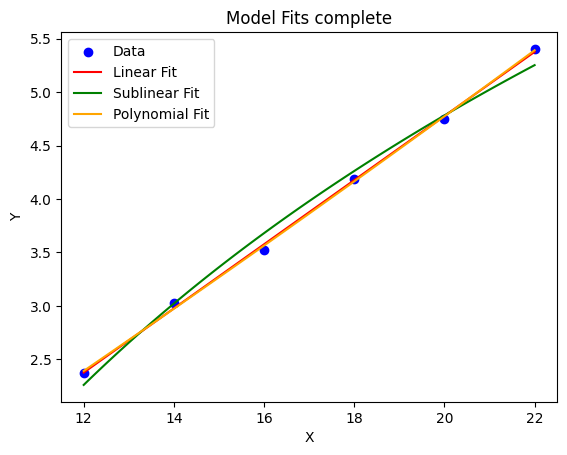

In [279]:
# 1. Define the candidate models
def linear_model(x, a, b):
    return a*x + b

def sublinear_model(x, a, b):
    return a * np.log(x) + b 

def polynomial_model(x, a, b, c):
    return a * x**2 + b * x + c

for graph in graph_type_list:
    color = color_map.get(graph, "black")
    entropies = []
    for nqubits in num_variables_list:
        entropies.append(entropy_results_dict['True'][f'{nqubits}'][graph][0])


    # 2. Generate or load your data (replace these with your data)
    # x_data = np.linspace(1, 10, 50)  # Replace with your x values
    # y_data = 2.5 * x_data + 3 + np.random.normal(0, 2, len(x_data))  # Replace with your y values
    x_data = np.array([float(variable) for variable in num_variables_list])
    y_data = np.array(entropies)
    print(x_data)
    print(y_data)

    # 3. Fit the data to each model
    params_linear, _ = curve_fit(linear_model, x_data, y_data)
    params_sublinear, _ = curve_fit(sublinear_model, x_data, y_data)
    params_polynomial, _ = curve_fit(polynomial_model, x_data, y_data)

    print('linear',params_linear)
    print('sub', params_sublinear)
    print('poly', params_polynomial)

    # 4. Calculate goodness-of-fit (sum of squared residuals)
    def compute_ssr(model, params, x, y):
        y_fit = model(x, *params)
        residuals = y - y_fit
        return np.sum(residuals**2)

    ssr_linear = compute_ssr(linear_model, params_linear, x_data, y_data)
    ssr_sublinear = compute_ssr(sublinear_model, params_sublinear, x_data, y_data)
    ssr_polynomial = compute_ssr(polynomial_model, params_polynomial, x_data, y_data)

    # Print SSR values for comparison
    print(f"Sum of Squared Residuals (SSR):")
    print(f"  Linear Model: {ssr_linear:.2f}")
    print(f"  Sublinear Model: {ssr_sublinear:.2f}")
    print(f"  Polynomial Model: {ssr_polynomial:.2f}")

    # 5. Plot the data and fits
    plt.scatter(x_data, y_data, label="Data", color="blue")

    # Generate x values for plotting fits
    x_fit = np.linspace(min(x_data), max(x_data), 100)

    # Plot the fitted models
    plt.plot(x_fit, linear_model(x_fit, *params_linear), label="Linear Fit", color="red")
    plt.plot(x_fit, sublinear_model(x_fit, *params_sublinear), label="Sublinear Fit", color="green")
    plt.plot(x_fit, polynomial_model(x_fit, *params_polynomial), label="Polynomial Fit", color="orange")

    # Add labels, legend, and show the plot
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.title(f'Model Fits {graph}')
    plt.show()


tau =  0.3 alpha =  0.01 qubits =  12 parameters = 48

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 56

tau =  0.3 alpha =  0.01 qubits =  16 parameters = 64

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 72

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 80

tau =  0.3 alpha =  0.01 qubits =  22 parameters = 88

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 78

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 106

tau =  0.3 alpha =  0.01 qubits =  16 parameters = 136

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 170

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 210

tau =  0.3 alpha =  0.01 qubits =  22 parameters = 254

tau =  0.3 alpha =  0.01 qubits =  12 parameters = 104

tau =  0.3 alpha =  0.01 qubits =  14 parameters = 142

tau =  0.3 alpha =  0.01 qubits =  16 parameters = 184

tau =  0.3 alpha =  0.01 qubits =  18 parameters = 232

tau =  0.3 alpha =  0.01 qubits =  20 parameters = 286

tau =  0.3 alpha =  0.01 qubits =  22 parameters = 346

KeyboardInterrupt: 

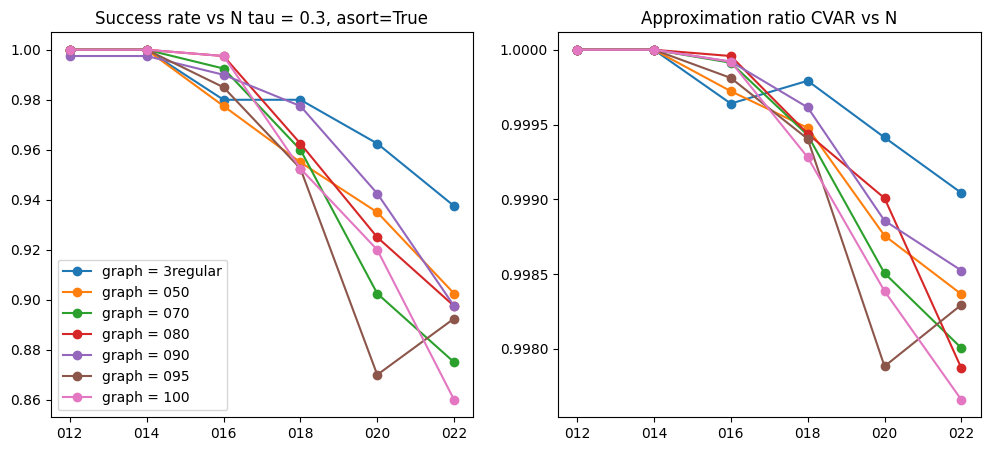

In [280]:
num_variables_list = [str(num).zfill(3) for num in range(12,24, 2)] 
graph_type_list = [ '3regular', '050', '070', '080', '090', '095', '100','complete']

r_list = range(400)
tau_list =[0.3] # [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)
if_adsorting = True

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

for graph in graph_type_list:

    dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                            .format(graph,  shots)
    
    sr_array = np.zeros((len(num_opt_list), len(num_variables_list)))
    ar_array = np.zeros(len(num_variables_list))

    for n_qubits_i, num_variables in enumerate(num_variables_list):
        n_qubits = int(num_variables)

        N = n_qubits
        
        if graph == 'complete':
            # pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
            # num_pairs = len(pairs_all)
            # num_params = (n_qubits + 2*num_pairs) * layer
            # print(num_pairs, num_params)
            num_params = int(2*(N-1)*N/2 + N)
        elif graph == '3regular':
            num_params= int(2*(3*N)/2 + N)
        elif graph == '100':
            density = 1
            num_params = 2*round((N-1)*N*density/2) +N
        else:
            density = float(f"0.{int(graph)}")
            num_params = 2*round((N-1)*N*density/2) +N

        for alpha in alpha_list:

            for taui, tau in enumerate(tau_list):
                print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)

                dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                    .format(num_variables, num_params, layer, alpha)
                
                for r in r_list:
                    # filename = f"./data_sorting/ansatz_type_structure_like_qubo_YZ_2/shots_None/layer_1/alpha_{alpha}/initial_warm_start_measure/r_{r}/tau_{tau}_random.pkl"
                    
                    file_dir_name = dir_name + '/r_{}'\
                                .format(r)
                    
                    filename = file_dir_name + '/ifadsorting_{}_tau_{}_entro.pkl'\
                                                            .format(if_adsorting,tau)
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)

                    params_list = data["params_list"]
                    if len(params_list) != round(num_params):
                        print("error N, r = ", r, len(params_list))
                        
                    steps_exp_poss_dict = data["steps_exp_poss_dict"]
                    steps_cvar_dict = data["steps_cvar_dict"]
                    steps_entropy_dict = data["steps_entropy_dict"]
                    
                    final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                    poss_list = list(final_exp_poss.values())
                    if poss_list[0] > alpha:
                        sr_array[0, n_qubits_i] += 1/len(r_list)
                    if sum(poss_list[:2]) > alpha:
                        sr_array[1, n_qubits_i] += 1/len(r_list)
                    if sum(poss_list[:3]) > alpha:
                        sr_array[2, n_qubits_i] += 1/len(r_list)

                    exp_opt = list(final_exp_poss.keys())[0]
                    cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]
                    ar_array[n_qubits_i] += (cvar/exp_opt) / len(r_list)

    # print("sr_array = ", sr_array)
    ax1.plot(num_variables_list, sr_array[0], "o-", label=f"graph = {graph}")
    # ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
    # ax1.plot(tau_list, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

    ax2.plot(num_variables_list, ar_array, "o-", label=f"graph = {graph}")
    # print("ar_array = ", ar_array)

    ax1.set_title(f'Success rate vs N tau = {tau}, asort={if_adsorting}')
    ax2.set_title('Approximation ratio CVAR vs N')

    ax1.legend()
plt.legend()
plt.xlabel("N")
plt.ylabel("success rate")
plt.show()

In [ ]:
from statsmodels.stats.proportion import proportion_confint
p_low, p_upp = proportion_confint(count=sr*N_random, nobs=N_random, alpha=0.05, method="wilson")        
lerror_list.append(sr-p_low)
uerror_list.append(p_upp-sr)
ax1.errorbar(shots_list, y = sr_list, yerr = [lerror_list, uerror_list])

In [ ]:
num_variables_list = [str(num).zfill(3) for num in range(12,24, 2)] 
graph_type_list = [ '3regular', '050', '070', '080', '090', '095', '100','complete']

r_list = range(400)
tau_list =[0.3] # [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)
if_adsorting = True

num_opt_list = [1,2,3]
color_list = ["green", "blue", "red"]
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

for graph in graph_type_list:

    dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                            .format(graph,  shots)
    
    sr_array = np.zeros((len(num_opt_list), len(num_variables_list)))
    ar_array = np.zeros(len(num_variables_list))

    for n_qubits_i, num_variables in enumerate(num_variables_list):
        n_qubits = int(num_variables)

        N = n_qubits
        
        if graph == 'complete':
            num_params = int(2*(N-1)*N/2 + N)
        elif graph == '3regular':
            num_params= int(2*(3*N)/2 + N)
        elif graph == '100':
            density = 1
            num_params = 2*round((N-1)*N*density/2) +N
        else:
            density = float(f"0.{int(graph)}")
            num_params = 2*round((N-1)*N*density/2) +N

        for alpha in alpha_list:

            for taui, tau in enumerate(tau_list):
                print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)

                dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                    .format(num_variables, num_params, layer, alpha)
                
                for r in r_list:
                    
                    file_dir_name = dir_name + '/r_{}'\
                                .format(r)
                    
                    filename = file_dir_name + '/ifadsorting_{}_tau_{}_entro.pkl'\
                                                            .format(if_adsorting,tau)
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)

                    params_list = data["params_list"]
                    if len(params_list) != round(num_params):
                        print("error N, r = ", r, len(params_list))
                        
                    steps_exp_poss_dict = data["steps_exp_poss_dict"]
                    steps_cvar_dict = data["steps_cvar_dict"]
                    steps_entropy_dict = data["steps_entropy_dict"]
                    
                    final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                    poss_list = list(final_exp_poss.values())
                    if poss_list[0] > alpha:
                        sr_array[0, n_qubits_i] += 1/len(r_list)
                    if sum(poss_list[:2]) > alpha:
                        sr_array[1, n_qubits_i] += 1/len(r_list)
                    if sum(poss_list[:3]) > alpha:
                        sr_array[2, n_qubits_i] += 1/len(r_list)

                    exp_opt = list(final_exp_poss.keys())[0]
                    cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]
                    ar_array[n_qubits_i] += (cvar/exp_opt) / len(r_list)

    # print("sr_array = ", sr_array)
    ax1.plot(num_variables_list, sr_array[0], "o-", label=f"graph = {graph}")
    # ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
    # ax1.plot(tau_list, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

    ax2.plot(num_variables_list, ar_array, "o-", label=f"graph = {graph}")
    # print("ar_array = ", ar_array)

    ax1.set_title(f'Success rate vs N tau = {tau}, asort={if_adsorting}')
    ax2.set_title('Approximation ratio CVAR vs N')

    ax1.legend()
plt.legend()
plt.xlabel("N")
plt.ylabel("success rate")
plt.show()

In [ ]:
# Initialize the dictionary using dictionary comprehension
solution_dict = {
'old' : {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]},
'lightcone' :  {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]} }
iteoverlap_dict = {
'old' : {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]},
'lightcone' :  {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]} }


# Initialize the dictionary using dictionary comprehension
results_dict = {
'old' : {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]},
'lightcone' :  {f'Sort_{Abs}_{invert}': [] for Abs in [True, False] for invert in [True, False]} }

graph_type_list = [ '3regular', '050', '070', '080', '090', '095', '100','complete']
num_variables_list = [str(num).zfill(3) for num in range(12,24, 2)] 

results_dict = {
'qubita' : {f'{graph}': [] for graph in graph_type_list}}
print(results_dict)

results_dict = {}

results_dict = {
f'{nqubits}' : {f'{graph}': [] for graph in graph_type_list} for nqubits in num_variables_list}
print(results_dict)

{'qubita': {'3regular': [], '050': [], '070': [], '080': [], '090': [], '095': [], '100': [], 'complete': []}}
{'012': {'3regular': [], '050': [], '070': [], '080': [], '090': [], '095': [], '100': [], 'complete': []}, '014': {'3regular': [], '050': [], '070': [], '080': [], '090': [], '095': [], '100': [], 'complete': []}, '016': {'3regular': [], '050': [], '070': [], '080': [], '090': [], '095': [], '100': [], 'complete': []}, '018': {'3regular': [], '050': [], '070': [], '080': [], '090': [], '095': [], '100': [], 'complete': []}, '020': {'3regular': [], '050': [], '070': [], '080': [], '090': [], '095': [], '100': [], 'complete': []}, '022': {'3regular': [], '050': [], '070': [], '080': [], '090': [], '095': [], '100': [], 'complete': []}}


In [ ]:
print(results_dict['022'])

{'3regular': [], '050': [], '070': [], '080': [], '090': [], '095': [], '100': [], 'complete': []}


In [ ]:
density_list = [] 

for graph in graph_type_list:
    if graph == 'complete':
        density =1
    elif graph == '3regular':
        density = ((3*N)/2)/((N-1)*N/2 )
    elif graph == '100':
        density = 1
    else:
        density = float(f"0.{int(graph)}")

    density_list.

In [ ]:
r_list = range(100) # range(400)
tau_list =[0.3] # [0.3, 0.4]
alpha_list = [0.01]
layer = 1
shots = None
tot_steps = range(5)
if_adsorting = True



In [ ]:
graph_type_list = [ '3regular', '050', '070', '080', '090', '095', '100','complete']
num_variables_list = [str(num).zfill(3) for num in range(12,24, 2)] 

entropy_results_dict = {f'{abs}' : {
f'{nqubits}' : {f'{graph}': [0,0] for graph in graph_type_list} for nqubits in num_variables_list} for abs in [True, False]}
print(entropy_results_dict)

cvar_results_dict =  {f'{abs}' : {
f'{nqubits}' : {f'{graph}': [0,0] for graph in graph_type_list} for nqubits in num_variables_list} for abs in [True, False]}
print(cvar_results_dict)

fidelity_results_dict =  {f'{abs}' : {
f'{nqubits}' : {f'{graph}': [[0,0],[0,0],[0,0]] for graph in graph_type_list} for nqubits in num_variables_list} for abs in [True, False]}
print(fidelity_results_dict)

{'True': {'012': {'3regular': [0, 0], '050': [0, 0], '070': [0, 0], '080': [0, 0], '090': [0, 0], '095': [0, 0], '100': [0, 0], 'complete': [0, 0]}, '014': {'3regular': [0, 0], '050': [0, 0], '070': [0, 0], '080': [0, 0], '090': [0, 0], '095': [0, 0], '100': [0, 0], 'complete': [0, 0]}, '016': {'3regular': [0, 0], '050': [0, 0], '070': [0, 0], '080': [0, 0], '090': [0, 0], '095': [0, 0], '100': [0, 0], 'complete': [0, 0]}, '018': {'3regular': [0, 0], '050': [0, 0], '070': [0, 0], '080': [0, 0], '090': [0, 0], '095': [0, 0], '100': [0, 0], 'complete': [0, 0]}, '020': {'3regular': [0, 0], '050': [0, 0], '070': [0, 0], '080': [0, 0], '090': [0, 0], '095': [0, 0], '100': [0, 0], 'complete': [0, 0]}, '022': {'3regular': [0, 0], '050': [0, 0], '070': [0, 0], '080': [0, 0], '090': [0, 0], '095': [0, 0], '100': [0, 0], 'complete': [0, 0]}}, 'False': {'012': {'3regular': [0, 0], '050': [0, 0], '070': [0, 0], '080': [0, 0], '090': [0, 0], '095': [0, 0], '100': [0, 0], 'complete': [0, 0]}, '014':

In [ ]:

for graph in graph_type_list:

    dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                            .format(graph,  shots)

    for n_qubits_i, num_variables in enumerate(num_variables_list):
        n_qubits = int(num_variables)

        N = n_qubits
        
        if graph == 'complete':
            num_params = int(2*(N-1)*N/2 + N)
        elif graph == '3regular':
            num_params= int(2*(3*N)/2 + N)
        elif graph == '100':
            density = 1
            num_params = 2*round((N-1)*N*density/2) +N
        else:
            density = float(f"0.{int(graph)}")
            num_params = 2*round((N-1)*N*density/2) +N

        print("qubits = ", N, "parameters =", num_params)
            
        for alpha in alpha_list:

            for taui, tau in enumerate(tau_list):
                
                #print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)
                
                dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                    .format(num_variables, num_params, layer, alpha)
                
                for r in r_list:
                    
                    file_dir_name = dir_name + '/r_{}'\
                                .format(r)
                    
                    filename = file_dir_name + '/ifadsorting_{}_tau_{}_entro.pkl'\
                                                            .format(if_adsorting,tau)
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)

                    params_list = data["params_list"]
                    if len(params_list) != round(num_params):
                        print("error N, r = ", r, len(params_list))
                        
                    steps_exp_poss_dict = data["steps_exp_poss_dict"]
                    steps_cvar_dict = data["steps_cvar_dict"]
                    steps_entropy_dict = data["steps_entropy_dict"]
                    
                    final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                    poss_list = list(final_exp_poss.values())

                    if poss_list[0] > alpha:
                        fidelity_results_dict[f'{num_variables}'][f'{graph}'][0] += 1/len(r_list)
                    if sum(poss_list[:2]) > alpha:
                        fidelity_results_dict[f'{num_variables}'][f'{graph}'][1] += 1/len(r_list)
                    if sum(poss_list[:3]) > alpha:
                        fidelity_results_dict[f'{num_variables}'][f'{graph}'][2] += 1/len(r_list)

                    exp_opt = list(final_exp_poss.keys())[0]
                    cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]
                    cvar_results_dict[f'{num_variables}'][f'{graph}'] += (cvar/exp_opt) / len(r_list)

#     # print("sr_array = ", sr_array)
#     ax1.plot(num_variables_list, sr_array[0], "o-", label=f"graph = {graph}")
#     # ax1.plot(tau_list, sr_array[1], "o--",label=f"alpha = {alpha}, num_opt = 2")
#     # ax1.plot(tau_list, sr_array[2], "o:",label=f"alpha = {alpha}, num_opt = 3")

#     ax2.plot(num_variables_list, ar_array, "o-", label=f"graph = {graph}")
#     # print("ar_array = ", ar_array)

#     ax1.set_title(f'Success rate vs N tau = {tau}, asort={if_adsorting}')
#     ax2.set_title('Approximation ratio CVAR vs N')

#     ax1.legend()
# plt.legend()
# plt.xlabel("N")
# plt.ylabel("success rate")
# plt.show()

qubits =  12 parameters = 48
qubits =  14 parameters = 56
qubits =  16 parameters = 64
qubits =  18 parameters = 72
qubits =  20 parameters = 80
qubits =  22 parameters = 88
qubits =  12 parameters = 78
qubits =  14 parameters = 106
qubits =  16 parameters = 136
qubits =  18 parameters = 170
qubits =  20 parameters = 210
qubits =  22 parameters = 254
qubits =  12 parameters = 104
qubits =  14 parameters = 142
qubits =  16 parameters = 184
qubits =  18 parameters = 232
qubits =  20 parameters = 286
qubits =  22 parameters = 346
qubits =  12 parameters = 118
qubits =  14 parameters = 160
qubits =  16 parameters = 208
qubits =  18 parameters = 262
qubits =  20 parameters = 324
qubits =  22 parameters = 392
qubits =  12 parameters = 130
qubits =  14 parameters = 178
qubits =  16 parameters = 232
qubits =  18 parameters = 294
qubits =  20 parameters = 362
qubits =  22 parameters = 438
qubits =  12 parameters = 138
qubits =  14 parameters = 186
qubits =  16 parameters = 244
qubits =  18 para

In [ ]:
print(fidelity_results_dict)

{'012': {'3regular': [2.0000000000000013, 2.0000000000000013, 2.0000000000000013], '050': [2.0000000000000013, 2.0000000000000013, 2.0000000000000013], '070': [2.0000000000000013, 2.0000000000000013, 2.0000000000000013], '080': [2.0000000000000013, 2.0000000000000013, 2.0000000000000013], '090': [2.0000000000000013, 2.0000000000000013, 2.0000000000000013], '095': [2.0000000000000013, 2.0000000000000013, 2.0000000000000013], '100': [2.0000000000000013, 2.0000000000000013, 2.0000000000000013], 'complete': [2.0000000000000013, 2.0000000000000013, 2.0000000000000013]}, '014': {'3regular': [2.0000000000000013, 2.0000000000000013, 2.0000000000000013], '050': [2.0000000000000013, 2.0000000000000013, 2.0000000000000013], '070': [2.0000000000000013, 2.0000000000000013, 2.0000000000000013], '080': [2.0000000000000013, 2.0000000000000013, 2.0000000000000013], '090': [2.0000000000000013, 2.0000000000000013, 2.0000000000000013], '095': [2.0000000000000013, 2.0000000000000013, 2.0000000000000013], '

[1.0, 1.0, 0.99, 0.97, 0.94, 0.91]
[0.0, 0.0, 0.0195013954179879, 0.033434480956371804, 0.046546565661405026, 0.0560905943465434]
[0.0, 0.0, 0.01, 0.03, 0.046547, 0.056091]
0.9660905943465434
0.8539094056534566
[1.0, 1.0, 0.96, 0.94, 0.85, 0.93]
[0.0, 0.0, 0.03840729341084248, 0.046546565661405026, 0.06998471259057237, 0.050007896299203325]
[0.0, 0.0, 0.038407, 0.046547, 0.069985, 0.050008]
0.9800078962992034
0.8799921037007967
[1.0, 1.0, 1.0, 0.95, 0.89, 0.83]
[0.0, 0.0, 0.0, 0.04271642470794712, 0.06132526547402428, 0.07362267582748816]
[0.0, 0.0, 0.0, 0.042716, 0.061325, 0.073623]
0.9036226758274881
0.7563773241725118
100


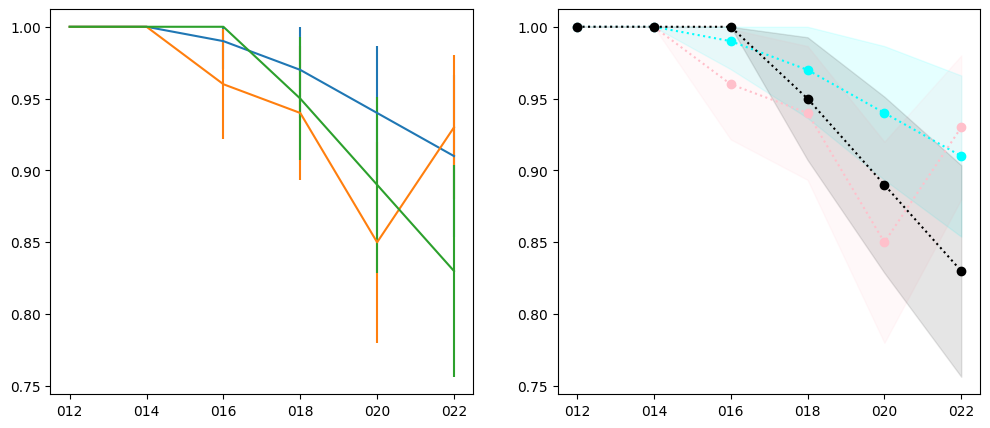

In [ ]:
from statsmodels.stats.proportion import proportion_confint

f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

color_map = {
    "complete": "blue",
    "3regular": "green",
    "050": "red",
    "070": "purple",
    "080": "orange",
    "090": "cyan",
    "095": "pink",
}

for graph in ['090', '095','100']:

    fidelities = [] 
    lerror_list = []
    uerror_list = []
    lerror_list2 = []
    uerror_list2 = []
    for n_qubits_i, num_variables in enumerate(num_variables_list):
        current_fid = np.round(fidelity_results_dict[f'{num_variables}'][f'{graph}'][0],6)
        p_low, p_upp = proportion_confint(count=current_fid*len(r_list), nobs=len(r_list), alpha=0.05, method="wilson") 
        p_low, p_upp = proportion_confint(count=current_fid*len(r_list), nobs=len(r_list), alpha=0.05, method="normal") 
        fidelities.append(current_fid)      
        lerror_list.append(current_fid-p_low)
        uerror_list.append(np.round(p_upp- current_fid,6))
        lerror_list2.append(p_low)
        uerror_list2.append(p_upp)
    print(fidelities)
    print(lerror_list)
    print(uerror_list)
    print(p_upp)
    print(p_low)
    color = color_map.get(graph, "black")
    ax1.errorbar(num_variables_list, y = fidelities, yerr = [lerror_list, uerror_list])
    ax2.plot(num_variables_list, fidelities,"o:", color=color)
    ax2.fill_between(num_variables_list, lerror_list2, uerror_list2, color=color, alpha=0.1, label="95% CI")
print(len(r_list))

In [ ]:
from statsmodels.stats.proportion import proportion_confint
p_low, p_upp = proportion_confint(count=sr*N_random, nobs=N_random, alpha=0.05, method="wilson")        
lerror_list.append(sr-p_low)
uerror_list.append(p_upp-sr)
ax1.errorbar(shots_list, y = sr_list, yerr = [lerror_list, uerror_list])

[1.0, 1.0, 0.999968, 0.999652, 0.998754, 0.998805]
[0.0, 0.0, 0.0011087053197694763, 0.0036556291573033306, 0.006914111486158059, 0.0067713053331660555]
[0.0, 0.0, 3.2e-05, 0.000348, 0.001246, 0.001195]
[1.0, 1.0, 0.9988592946802305, 0.9959963708426967, 0.991839888513842, 0.992033694666834]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 0.999547, 0.999268, 0.998078, 0.999334]
[0.0, 0.0, 0.004170602527034828, 0.005300839094819598, 0.008584342247259125, 0.005056389692729257]
[0.0, 0.0, 0.000453, 0.000732, 0.001922, 0.000666]
[1.0, 1.0, 0.9953763974729651, 0.9939671609051804, 0.9894936577527409, 0.9942776103072707]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 0.999355, 0.998551, 0.99761]
[0.0, 0.0, 0.0, 0.004976085606620773, 0.007455339227965818, 0.009570341574118069]
[0.0, 0.0, 0.0, 0.000645, 0.001449, 0.00239]
[1.0, 1.0, 1.0, 0.9943789143933792, 0.9910956607720341, 0.9880396584258819]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
100


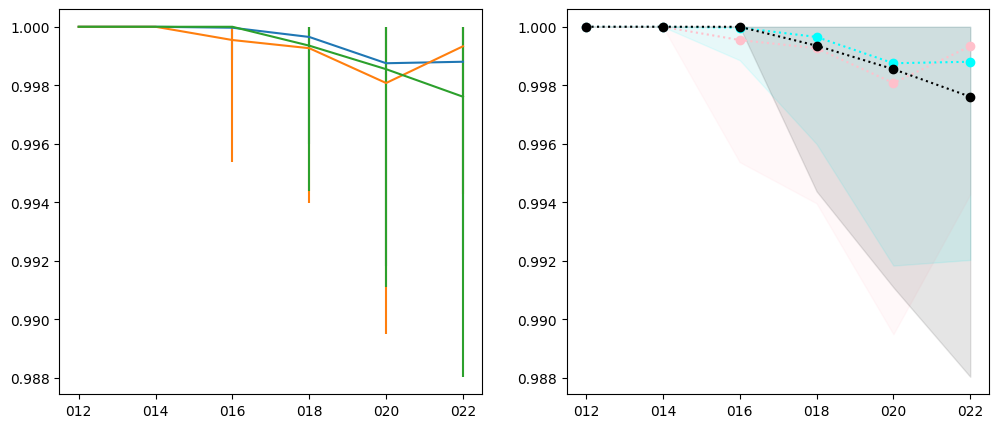

In [ ]:
from statsmodels.stats.proportion import proportion_confint

f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

color_map = {
    "complete": "blue",
    "3regular": "green",
    "050": "red",
    "070": "purple",
    "080": "orange",
    "090": "cyan",
    "095": "pink",
}

for graph in ['090', '095','100']:

    fidelities = [] 
    lerror_list = []
    uerror_list = []
    lerror_list2 = []
    uerror_list2 = []
    for n_qubits_i, num_variables in enumerate(num_variables_list):
        current_fid = np.round(cvar_results_dict[f'{num_variables}'][f'{graph}'][0],6)
        p_low, p_upp = proportion_confint(count=current_fid*len(r_list), nobs=len(r_list), alpha=0.05, method="wilson") 
        p_low, p_upp = proportion_confint(count=current_fid*len(r_list), nobs=len(r_list), alpha=0.05, method="normal") 
        fidelities.append(current_fid)      
        lerror_list.append(current_fid-p_low)
        uerror_list.append(np.round(p_upp- current_fid,6))
        lerror_list2.append(p_low)
        uerror_list2.append(p_upp)
    print(fidelities)
    print(lerror_list)
    print(uerror_list)
    print(lerror_list2)
    print(uerror_list2)
    color = color_map.get(graph, "black")
    ax1.errorbar(num_variables_list, y = fidelities, yerr = [lerror_list, uerror_list])
    ax2.plot(num_variables_list, fidelities,"o:", color=color)
    ax2.fill_between(num_variables_list, lerror_list2, uerror_list2, color=color, alpha=0.1, label="95% CI")
print(len(r_list))

In [ ]:
for graph in graph_type_list:

    dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                            .format(graph,  shots)

    for n_qubits_i, num_variables in enumerate(num_variables_list):
        n_qubits = int(num_variables)

        N = n_qubits
        
        if graph == 'complete':
            num_params = int(2*(N-1)*N/2 + N)
        elif graph == '3regular':
            num_params= int(2*(3*N)/2 + N)
        elif graph == '100':
            density = 1
            num_params = 2*round((N-1)*N*density/2) +N
        else:
            density = float(f"0.{int(graph)}")
            num_params = 2*round((N-1)*N*density/2) +N

        print("qubits = ", N, "parameters =", num_params)
            
        for alpha in alpha_list:

            for taui, tau in enumerate(tau_list):
                
                #print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)
                
                dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                    .format(num_variables, num_params, layer, alpha)
                
                successes = np.zeros((3, len(r_list)))
                # successes2 = np.zeros(len(r_list))
                # successes3 = np.zeros(len(r_list))
                max_entros = []
                cvarvalues = []

                for r in r_list:
                    
                    file_dir_name = dir_name + '/r_{}'\
                                .format(r)
                    
                    filename = file_dir_name + '/ifadsorting_{}_tau_{}_entro.pkl'\
                                                            .format(if_adsorting,tau)
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)

                    params_list = data["params_list"]
                    if len(params_list) != round(num_params):
                        print("error N, r = ", r, len(params_list))
                        
                    steps_exp_poss_dict = data["steps_exp_poss_dict"]
                    steps_cvar_dict = data["steps_cvar_dict"]
                    steps_entropy_dict = data["steps_entropy_dict"]
                    
                    final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                    poss_list = list(final_exp_poss.values())

                    if poss_list[0] > alpha:
                        successes[0][r] = 1
                    if sum(poss_list[:2]) > alpha:
                        successes[1][r] = 1
                    if sum(poss_list[:3]) > alpha:
                        successes[2][r] = 1

                    exp_opt = list(final_exp_poss.keys())[0]
                    cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]
                    cvarvalues.append(cvar/exp_opt)

                    max_key = max(steps_entropy_dict, key=steps_entropy_dict.get)
                    max_entros.append(steps_entropy_dict[max_key])
                
                cvar_results_dict[f'{num_variables}'][f'{graph}'][0] = np.mean(cvarvalues)
                cvar_results_dict[f'{num_variables}'][f'{graph}'][1] = np.std(cvarvalues, axis=0, ddof=1)

                entropy_results_dict[f'{num_variables}'][f'{graph}'][0] = np.mean(max_entros)
                entropy_results_dict[f'{num_variables}'][f'{graph}'][1] = np.std(max_entros, axis=0, ddof=1)

                for i in range(3):
                    fidelity_results_dict[f'{num_variables}'][f'{graph}'][i][0] = np.mean(successes[i])
                    fidelity_results_dict[f'{num_variables}'][f'{graph}'][i][1] = np.std(successes[i], axis=0, ddof=1)



qubits =  12 parameters = 48
qubits =  14 parameters = 56
qubits =  16 parameters = 64
qubits =  18 parameters = 72
qubits =  20 parameters = 80
qubits =  22 parameters = 88
qubits =  12 parameters = 78
qubits =  14 parameters = 106
qubits =  16 parameters = 136
qubits =  18 parameters = 170
qubits =  20 parameters = 210
qubits =  22 parameters = 254
qubits =  12 parameters = 104
qubits =  14 parameters = 142
qubits =  16 parameters = 184
qubits =  18 parameters = 232
qubits =  20 parameters = 286
qubits =  22 parameters = 346
qubits =  12 parameters = 118
qubits =  14 parameters = 160
qubits =  16 parameters = 208
qubits =  18 parameters = 262
qubits =  20 parameters = 324
qubits =  22 parameters = 392
qubits =  12 parameters = 130
qubits =  14 parameters = 178
qubits =  16 parameters = 232
qubits =  18 parameters = 294
qubits =  20 parameters = 362
qubits =  22 parameters = 438
qubits =  12 parameters = 138
qubits =  14 parameters = 186
qubits =  16 parameters = 244
qubits =  18 para

In [ ]:
for if_adsorting in [True]:  #CHANGE LATER!!!!!!!
    
    for graph in graph_type_list:

        dir_0 = './data_iter_adap_sorting' + '/graph_{}/shots_{}'\
                                .format(graph,  shots)

        for n_qubits_i, num_variables in enumerate(num_variables_list):
            n_qubits = int(num_variables)

            N = n_qubits
            
            if graph == 'complete':
                num_params = int(2*(N-1)*N/2 + N)
            elif graph == '3regular':
                num_params= int(2*(3*N)/2 + N)
            elif graph == '100':
                density = 1
                num_params = 2*round((N-1)*N*density/2) +N
            else:
                density = float(f"0.{int(graph)}")
                num_params = 2*round((N-1)*N*density/2) +N

            print("qubits = ", N, "parameters =", num_params)
                
            for alpha in alpha_list:

                for taui, tau in enumerate(tau_list):
                    
                    #print("\ntau = ", tau, "alpha = ", alpha, "qubits = ", N, "parameters =", num_params)
                    
                    dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}'\
                                        .format(num_variables, num_params, layer, alpha)
                    
                    successes = np.zeros((3, len(r_list)))
                    # successes2 = np.zeros(len(r_list))
                    # successes3 = np.zeros(len(r_list))
                    max_entros = []
                    cvarvalues = []

                    for r in r_list:
                        
                        file_dir_name = dir_name + '/r_{}'\
                                    .format(r)
                        
                        filename = file_dir_name + '/ifadsorting_{}_tau_{}_entro.pkl'\
                                                                .format(if_adsorting,tau)
                        with open(filename, 'rb') as f:
                            data = pickle.load(f)

                        params_list = data["params_list"]
                        if len(params_list) != round(num_params):
                            print("error N, r = ", r, len(params_list))
                            
                        steps_exp_poss_dict = data["steps_exp_poss_dict"]
                        steps_cvar_dict = data["steps_cvar_dict"]
                        steps_entropy_dict = data["steps_entropy_dict"]
                        
                        final_exp_poss = steps_exp_poss_dict[f"step_{len(tot_steps)-1}"]["l_1"]
                        poss_list = list(final_exp_poss.values())

                        if poss_list[0] > alpha:
                            successes[0][r] = 1
                        if sum(poss_list[:2]) > alpha:
                            successes[1][r] = 1
                        if sum(poss_list[:3]) > alpha:
                            successes[2][r] = 1

                        exp_opt = list(final_exp_poss.keys())[0]
                        cvar = steps_cvar_dict[f"step_{len(tot_steps)-1}"]
                        cvarvalues.append(cvar/exp_opt)

                        max_key = max(steps_entropy_dict, key=steps_entropy_dict.get)
                        max_entros.append(steps_entropy_dict[max_key])
                    
                    cvar_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][0] = np.mean(cvarvalues)
                    cvar_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][1] = np.std(cvarvalues, axis=0, ddof=1)

                    entropy_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][0] = np.mean(max_entros)
                    entropy_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][1] = np.std(max_entros, axis=0, ddof=1)

                    for i in range(3):
                        fidelity_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][i][0] = np.mean(successes[i])
                        fidelity_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][i][1] = np.std(successes[i], axis=0, ddof=1)

qubits =  12 parameters = 48
qubits =  14 parameters = 56
qubits =  16 parameters = 64
qubits =  18 parameters = 72
qubits =  20 parameters = 80
qubits =  22 parameters = 88
qubits =  12 parameters = 78
qubits =  14 parameters = 106
qubits =  16 parameters = 136
qubits =  18 parameters = 170
qubits =  20 parameters = 210
qubits =  22 parameters = 254
qubits =  12 parameters = 104
qubits =  14 parameters = 142
qubits =  16 parameters = 184
qubits =  18 parameters = 232
qubits =  20 parameters = 286
qubits =  22 parameters = 346
qubits =  12 parameters = 118
qubits =  14 parameters = 160
qubits =  16 parameters = 208
qubits =  18 parameters = 262
qubits =  20 parameters = 324
qubits =  22 parameters = 392
qubits =  12 parameters = 130
qubits =  14 parameters = 178
qubits =  16 parameters = 232
qubits =  18 parameters = 294
qubits =  20 parameters = 362
qubits =  22 parameters = 438
qubits =  12 parameters = 138
qubits =  14 parameters = 186
qubits =  16 parameters = 244
qubits =  18 para

In [ ]:
for x in num_variables_list:
    print(cvar_results_dict['True'][f'{x}']['090'])
print("\n")
for x in num_variables_list:
    print(entropy_results_dict['True'][f'{x}']['090'])
print("\n")
for x in num_variables_list:
    print(fidelity_results_dict['True'][f'{x}']['090'])

[1.0, 7.810712861838192e-17]
[1.0, 1.1158161231197418e-17]
[0.9999684004245938, 0.0003159957540622391]
[0.9996516494081357, 0.0023947447476943763]
[0.9987544250703951, 0.006559159824429137]
[0.998804914207314, 0.004664331223479647]


[2.3235833424999885, 0.21722600597026762]
[2.924429574512849, 0.24127925282102736]
[3.503775119552107, 0.2346735120130694]
[3.936001434091926, 0.25289170479372186]
[4.706054581153312, 0.2933656859545828]
[5.365037614410056, 0.3148984296697226]


[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]
[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]
[[0.99, 0.09999999999999999], [1.0, 0.0], [1.0, 0.0]]
[[0.97, 0.1714466079977653], [1.0, 0.0], [1.0, 0.0]]
[[0.94, 0.23868325657594203], [0.97, 0.1714466079977653], [0.98, 0.14070529413628968]]
[[0.91, 0.2876234912646614], [0.98, 0.14070529413628965], [0.99, 0.09999999999999999]]


In [ ]:
print(fidelity_results_dict)

{'012': {'3regular': [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]], '050': [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]], '070': [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]], '080': [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]], '090': [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]], '095': [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]], '100': [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]], 'complete': [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]}, '014': {'3regular': [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]], '050': [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]], '070': [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]], '080': [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]], '090': [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]], '095': [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]], '100': [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]], 'complete': [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]}, '016': {'3regular': [[0.97, 0.17144660799776532], [1.0, 0.0], [1.0, 0.0]], '050': [[0.99, 0.1], [1.0, 0.0], [1.0, 0.0]], '070': [[0.98, 0.14070529413628968], [1.0, 0.0], [1.0, 0.0]], '080': [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]], '090': [[0.99

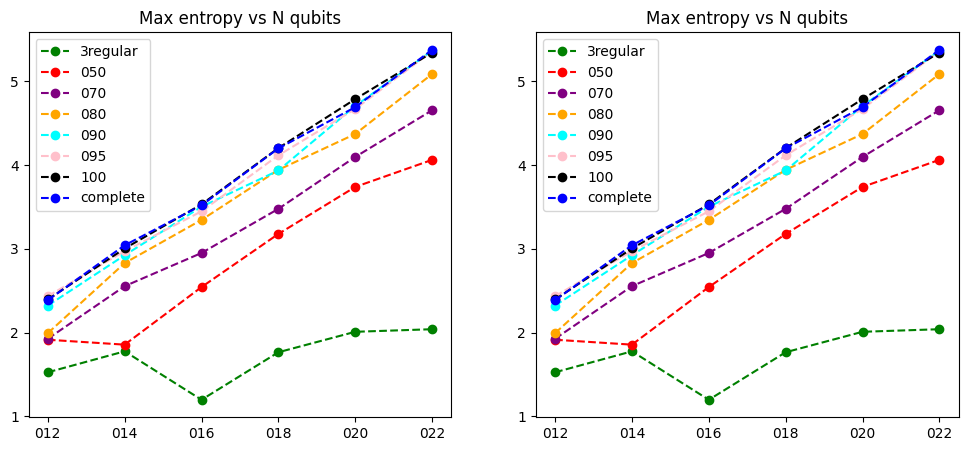

In [ ]:
f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

for graph in graph_type_list:
    color = color_map.get(graph, "black")
    entropies = []
    for nqubits in num_variables_list:
        entropies.append(entropy_results_dict['True'][f'{nqubits}'][graph][0])
    ax1.plot(num_variables_list, entropies, "o--", color = color, label = f'{graph}')
    ax1.set_title('Max entropy vs N qubits')
ax1.legend()

for graph in graph_type_list:
    color = color_map.get(graph, "black")
    entropies = []
    for nqubits in num_variables_list:
        entropies.append(entropy_results_dict['True'][f'{nqubits}'][graph][0])
    ax2.plot(num_variables_list, entropies, "o--", color = color, label = f'{graph}')
    ax2.set_title('Max entropy vs N qubits')
ax2.legend()


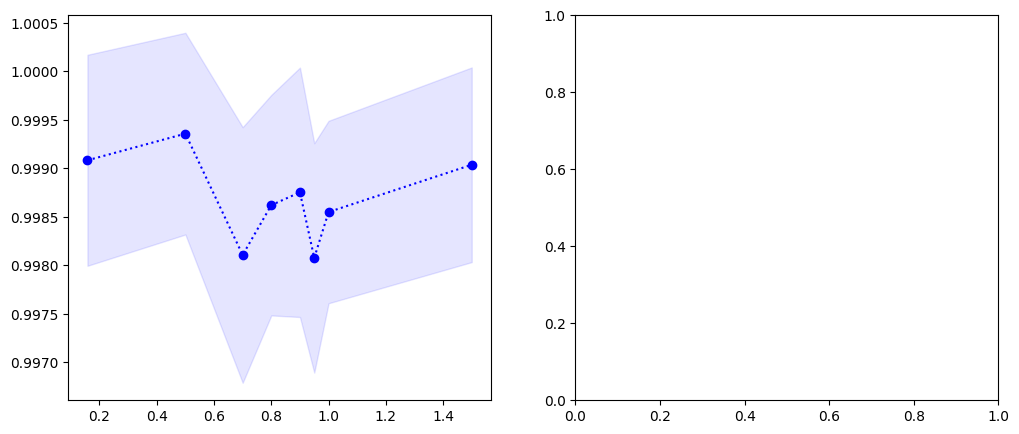

In [ ]:
density_list = []

f = plt.figure(figsize=(12, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

means = []
lows = []
ups = []

for graph in graph_type_list:

    num_variables = '020'
    N = 20

    if graph == 'complete':
        density =1.5 #ONLY FOR PLOT CLARITY!!
    elif graph == '3regular':
        density = ((3*N)/2)/((N-1)*N/2 )
    elif graph == '100':
        density = 1
    else:
        density = float(f"0.{int(graph)}")

    density_list.append(density)

    z = 1.96  # Z-score for 95% confidence

    mean = cvar_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][0]
    std = cvar_results_dict[f'{if_adsorting}'][f'{num_variables}'][f'{graph}'][1]

    # Compute confidence intervals
    margin_of_error = z * (std/ np.sqrt(len(r_list)))
    lower_bound = mean - margin_of_error 
    upper_bound = mean + margin_of_error 

    means.append(mean)
    lows.append(lower_bound)
    ups.append(upper_bound)

ax1.plot(density_list, means,"o:", color=color)
ax1.fill_between(density_list, lows, ups, color=color, alpha=0.1, label="95% CI")


